# 02. Proxy Default Labeling (FINAL)

## Vai trò
Dữ liệu SMEs tại Việt Nam thường không có default pháp lý (NPL/DPD).
Vì vậy, nghiên cứu xây dựng **proxy default** dựa trên stress tài chính.

Lưu ý quan trọng:
- Proxy default ≠ default pháp lý
- Proxy default phản ánh tình trạng stress tài chính nghiêm trọng
- Proxy default là nhãn cho mô hình dự đoán PD
- Credit Score 1–10 sẽ được tạo sau khi có PD (Notebook 04)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/NCKH"
DATA_RAW = f"{PROJECT_ROOT}/data/raw/final_research.csv"
DATA_PROCESSED = f"{PROJECT_ROOT}/data/processed"
SRC_DIR = f"{PROJECT_ROOT}/src"

import os, sys
os.makedirs(DATA_PROCESSED, exist_ok=True)
sys.path.append(SRC_DIR)

print("Setup done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup done


## Cơ sở proxy default (financial distress)

Một doanh nghiệp có rủi ro cao khi đồng thời có:
1) net_income < 0 (lỗ)
2) cashflow_ops < 0 (CFO âm)
3) interest_coverage < 1 (không đủ trả lãi)
4) debt_to_equity vượt ngưỡng lịch sử (đòn bẩy cao)

Proxy default = 1 nếu stress score ≥ 2.
Ngưỡng leverage chỉ được tính trên TRAIN để chống leakage.

In [14]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from features import load_raw_data, add_proxy_default
from config import ExperimentConfig

cfg = ExperimentConfig()
df = load_raw_data(DATA_RAW)

df_labeled, meta = add_proxy_default(
    df,
    train_year=cfg.TRAIN_YEAR,
    leverage_train_percentile=cfg.LEVERAGE_TRAIN_PERCENTILE,
    min_conditions=cfg.PROXY_DEFAULT_MIN_COUNT
)

meta

{'leverage_threshold': 1.7189817729603356, 'train_year': 2023}

## Phân phối proxy default
Kiểm tra tỷ lệ default tổng thể và theo năm để đánh giá tính hợp lý của nhãn.

In [15]:
df_labeled["proxy_default"].value_counts(normalize=True)

,proportion
proxy_default,
0,0.626932
1,0.373068


In [16]:
default_by_year = df_labeled.groupby("year")["proxy_default"].agg(default_rate="mean", n_obs="count").reset_index()
default_by_year

,year,default_rate,n_obs
0,2023,0.385965,228
1,2024,0.360000,225


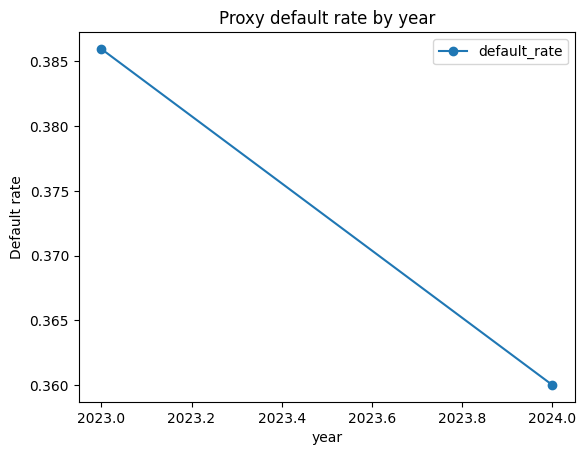

In [17]:
default_by_year.plot(x="year", y="default_rate", marker="o")
plt.title("Proxy default rate by year")
plt.ylabel("Default rate")
plt.show()

### Nhận xét
- Proxy default rate nằm trong khoảng hợp lý cho SMEs
- Xu hướng thay đổi theo năm phản ánh chu kỳ kinh tế
- Dữ liệu có **class imbalance vừa phải**, phù hợp cho mô hình PD

## Phân tích các điều kiện stress riêng lẻ

Mục tiêu:
- Hiểu mức độ phổ biến của từng dấu hiệu stress
- Đánh giá mức đóng góp tương đối vào proxy default

In [20]:
# tỷ lệ từng điều kiện
conditions = {
    "loss": (df_labeled["net_income"] < 0),
    "negative_cfo": (df_labeled["cashflow_ops"] < 0),
    "low_interest_coverage": (df_labeled["interest_coverage"] < 1),
    "high_leverage": (df_labeled["debt_to_equity_raw"] > meta["leverage_threshold"]),
}
pd.Series({k: float(v.mean()) for k, v in conditions.items()})

,0
loss,0.238411
negative_cfo,0.346578
low_interest_coverage,0.381898
high_leverage,0.253863


## Stress score
Stress score = số điều kiện stress thỏa (0–4).
Proxy default = 1 nếu stress score ≥ 2.


In [21]:
df_labeled["distress_score"].value_counts().sort_index()

,count
distress_score,
0,165
1,119
2,89
3,64
4,16


In [22]:
df_labeled["distress_score"].value_counts(normalize=True).sort_index()

,proportion
distress_score,
0,0.364238
1,0.262693
2,0.196468
3,0.141280
4,0.035320


## Sensitivity Analysis

Để đảm bảo proxy default không phụ thuộc vào một lựa chọn ngưỡng duy nhất,
thực hiện kiểm tra độ nhạy với:
- Ngưỡng leverage khác nhau (70%, 75%, 80%)
- Số điều kiện stress khác nhau (≥1, ≥2, ≥3)

In [25]:
# Sensitivity theo leverage threshold
sens_leverage = []
for q in [0.7, 0.75, 0.8]:
    tmp, _ = add_proxy_default(df, train_year=cfg.TRAIN_YEAR, leverage_train_percentile=q, min_conditions=cfg.PROXY_DEFAULT_MIN_COUNT)
    sens_leverage.append({"leverage_quantile": q, "default_rate": float(tmp["proxy_default"].mean())})
pd.DataFrame(sens_leverage)

,leverage_quantile,default_rate
0,0.70,0.388521
1,0.75,0.373068
2,0.80,0.357616


In [26]:
# Sensitivity theo số điều kiện
sens_k = []
for k in [1, 2, 3]:
    tmp, _ = add_proxy_default(df, train_year=cfg.TRAIN_YEAR, leverage_train_percentile=cfg.LEVERAGE_TRAIN_PERCENTILE, min_conditions=k)
    sens_k.append({"min_conditions": k, "default_rate": float(tmp["proxy_default"].mean())})
pd.DataFrame(sens_k)

,min_conditions,default_rate
0,1,0.635762
1,2,0.373068
2,3,0.176600


### Kết luận sensitivity
Chọn:
- leverage threshold = 75% (tính trên train)
- min_conditions = 2

Vì:
- ≥1 quá nhạy (nhiễu)
- ≥3 quá khắt khe (thiếu mẫu default)
- ≥2 cân bằng giữa độ nhạy và độ ổn định

## Lưu dữ liệu đã gán nhãn + metadata
Đảm bảo reproducibility và phục vụ modeling (Notebook 03).

In [28]:
output_data = f"{DATA_PROCESSED}/data_labeled.csv"
df_labeled.to_csv(output_data, index=False)

meta_path = f"{DATA_PROCESSED}/labeling_meta.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

output_data, meta_path

('/content/drive/MyDrive/NCKH/data/processed/data_labeled.csv',
 '/content/drive/MyDrive/NCKH/data/processed/labeling_meta.json')